In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import joblib

# Load dataset
df = pd.read_csv("/content/drive/MyDrive/Rainfall_Data_2017_2023.csv")

# Drop missing data
df.dropna(subset=['State/UT', 'District', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                  'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], inplace=True)

# Filter for training data (before 2025)
df = df[df['Year'] < 2025]

# Encode categorical inputs
le_state = LabelEncoder()
le_district = LabelEncoder()
df['State/UT'] = le_state.fit_transform(df['State/UT'])
df['District'] = le_district.fit_transform(df['District'])

# Features and targets
X = df[['State/UT', 'District']]
month_cols = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
              'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
y = df[month_cols]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Multi-output regression
model = MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=42))
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Accuracy: R² and MAE per month
print("\nMonthly Accuracy Metrics:")
for i, month in enumerate(month_cols):
    r2 = r2_score(y_test.iloc[:, i], y_pred[:, i])
    mae = mean_absolute_error(y_test.iloc[:, i], y_pred[:, i])
    print(f"{month}: R² = {r2:.4f}, MAE = {mae:.2f} mm")

# Overall scores
overall_r2 = r2_score(y_test, y_pred, multioutput='uniform_average')
overall_mae = mean_absolute_error(y_test, y_pred)
print(f"\nOverall R² Score : {overall_r2:.4f}")
print(f"Overall MAE      : {overall_mae:.2f} mm")

# Save model + encoders
joblib.dump(model, "rainfall_monthly_model.pkl")
joblib.dump(le_state, "state_encoder.pkl")
joblib.dump(le_district, "district_encoder.pkl")



Monthly Accuracy Metrics:
Jan: R² = 0.9498, MAE = 10.84 mm
Feb: R² = 0.9536, MAE = 10.55 mm
Mar: R² = 0.9522, MAE = 10.72 mm
Apr: R² = 0.9547, MAE = 10.93 mm
May: R² = 0.9518, MAE = 11.00 mm
Jun: R² = 0.9501, MAE = 10.88 mm
Jul: R² = 0.9555, MAE = 10.43 mm
Aug: R² = 0.9560, MAE = 10.36 mm
Sep: R² = 0.9541, MAE = 10.76 mm
Oct: R² = 0.9515, MAE = 11.04 mm
Nov: R² = 0.9527, MAE = 10.73 mm
Dec: R² = 0.9504, MAE = 10.87 mm

Overall R² Score : 0.9527
Overall MAE      : 10.76 mm


['district_encoder.pkl']

In [3]:
# Overall scores
overall_r2 = r2_score(y_test, y_pred, multioutput='uniform_average')
overall_mae = mean_absolute_error(y_test, y_pred)

print(f"\nOverall Accuracy Metrics:")
print(f"R² Score : {overall_r2:.4f}")
print(f"MAE      : {overall_mae:.2f} mm")



Overall Accuracy Metrics:
R² Score : 0.9527
MAE      : 10.76 mm


In [7]:
import joblib
import numpy as np

# Load the trained model and encoders
model = joblib.load("rainfall_monthly_model.pkl")
le_state = joblib.load("state_encoder.pkl")
le_district = joblib.load("district_encoder.pkl")

# Input: State and District name (as seen in training data)
input_state = "MAHARASHTRA"     # 👈 change as needed
input_district = "Nagpur"  # 👈 change as needed

# Encode inputs
try:
    state_encoded = le_state.transform([input_state])[0]
    district_encoded = le_district.transform([input_district])[0]

    # Prepare input for prediction
    import pandas as pd
    input_features = pd.DataFrame([[state_encoded, district_encoded]], columns=['State/UT', 'District'])


    # Predict rainfall for each month
    prediction = model.predict(input_features)[0]

    # Month labels
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
              'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

    # Print predictions
    print(f"\n🌧️ Predicted Rainfall for {input_district}, {input_state} (2025–2026):")
    for month, value in zip(months, prediction):
        print(f"{month}: {value:.2f} mm")

except ValueError as e:
    print("Error:", e)
    print("Make sure the state and district names match the training data.")



🌧️ Predicted Rainfall for Nagpur, MAHARASHTRA (2025–2026):
Jan: 249.38 mm
Feb: 75.52 mm
Mar: 76.01 mm
Apr: 158.07 mm
May: 199.64 mm
Jun: 234.06 mm
Jul: 102.42 mm
Aug: 146.30 mm
Sep: 124.13 mm
Oct: 115.27 mm
Nov: 118.01 mm
Dec: 189.34 mm


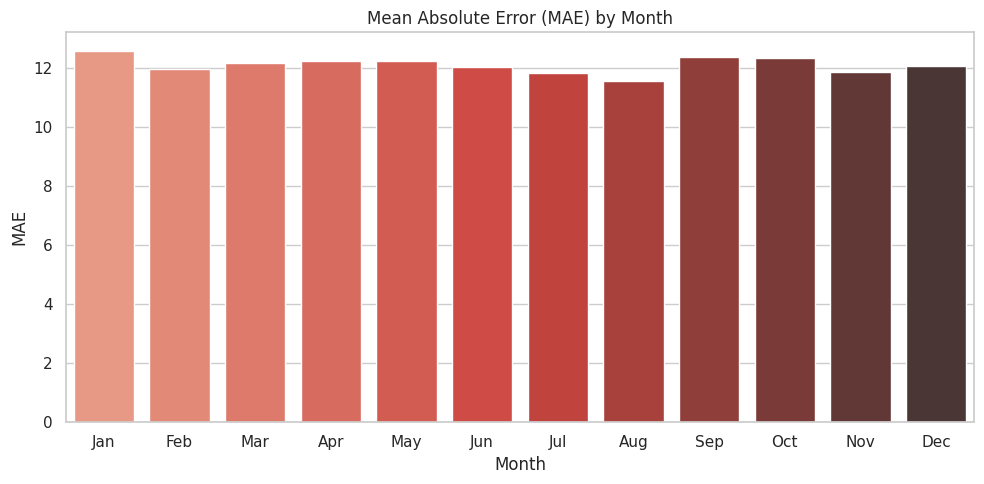

In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

# Calculate MAE scores
mae_scores = [mean_absolute_error(y_test.iloc[:, i], y_pred[:, i]) for i in range(len(month_cols))]
mae_df = pd.DataFrame({'Month': month_cols, 'MAE': mae_scores})

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(data=mae_df, x='Month', y='MAE', hue='Month', palette='Reds_d', legend=False)
plt.title("Mean Absolute Error (MAE) by Month")
plt.tight_layout()
plt.show()
